In [1]:
import os
import mdtraj as md
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA

In [2]:
def plot_potential_energy(md_platform, state_file_list, plot_type, window):
    energy_arrays = []
    labels = []
    for i, state_file in enumerate(state_file_list):
        if md_platform == 'openmm':
            df = pd.read_csv(state_file)
        elif md_platform == 'gromacs':
            csv_file = os.path.splitext(state_file)[0] + '.csv'
            with open(state_file, 'r') as fin, open(csv_file, 'w') as fout:
                for line in fin:
                    if not (line.startswith('@') or line.startswith('#')):
                        fout.write(','.join(line.split()) + '\n')
            #df = pd.read_csv(csv_file, header=None) #ignore the first row as initial state
            df = pd.read_csv(csv_file)
            df.columns = ['time', 'Potential Energy (kJ/mole)']
        energy = df['Potential Energy (kJ/mole)'].to_numpy()
        n_windows = len(energy) // window
        avg_energy = np.array([energy[i*window:(i+1)*window].mean() for i in range(n_windows)])
        avg_frames = np.arange(n_windows) * window
        energy_arrays.append(avg_energy)
        labels.append(f'replicate {i+1}')
        if plot_type == 'line':
            plt.plot(avg_frames, avg_energy, label=labels[-1])
            plt.xlabel('Frames')
            plt.ylabel('Potential Energy (kJ/mole)')
            plt.title(f'Potential Energy Over Time (Window = {window} frames)')
            #plt.ylim(np.mean(energy) - 5*np.std(energy), np.mean(energy) + 5*np.std(energy))
        elif plot_type == 'hist':
            sns.kdeplot(avg_energy, label=labels[-1])
            plt.xlabel('Potential Energy (kJ/mole)')
            plt.title('Potential Energy Distribution')
            #plt.xlim(np.mean(energy) - 5*np.std(energy), np.mean(energy) + 5*np.std(energy))
    plt.grid(True)
    plt.legend()
    plt.show()
    plt.close()
    #return energy_arrays

In [3]:
def plot_total_energy(md_platform, state_file_list, plot_type, window):
    energy_arrays = []
    labels = []
    for i, state_file in enumerate(state_file_list):
        if md_platform == 'openmm':
            df = pd.read_csv(state_file)
        elif md_platform == 'gromacs':
            csv_file = os.path.splitext(state_file)[0] + '.csv'
            with open(state_file, 'r') as fin, open(csv_file, 'w') as fout:
                for line in fin:
                    if not (line.startswith('@') or line.startswith('#')):
                        fout.write(','.join(line.split()) + '\n')
            #df = pd.read_csv(csv_file, header=None) #ignore the first row as initial state
            df = pd.read_csv(csv_file)
            df.columns = ['time', 'Total Energy (kJ/mole)']
        energy = df['Total Energy (kJ/mole)'].to_numpy()
        n_windows = len(energy) // window
        avg_energy = np.array([energy[i*window:(i+1)*window].mean() for i in range(n_windows)])
        avg_frames = np.arange(n_windows) * window
        energy_arrays.append(avg_energy)
        labels.append(f'replicate {i+1}')
        if plot_type == 'line':
            plt.plot(avg_frames, avg_energy, label=labels[-1])
            plt.xlabel('Frames')
            plt.ylabel('Total Energy (kJ/mole)')
            plt.title(f'Total Energy Over Time (Window = {window} frames)')
            #plt.ylim(np.mean(energy) - 5*np.std(energy), np.mean(energy) + 5*np.std(energy))
        elif plot_type == 'hist':
            sns.kdeplot(avg_energy, label=labels[-1])
            plt.xlabel('Total Energy (kJ/mole)')
            plt.title('Total Energy Distribution')
            #plt.xlim(np.mean(energy) - 5*np.std(energy), np.mean(energy) + 5*np.std(energy))
    plt.grid(True)
    plt.legend()
    plt.show()
    plt.close()
    #return energy_arrays

In [ ]:
plot_potential_energy('openmm', ['classic/classic_gaff/energy_data.csv'], 'line', 1)
plot_potential_energy('openmm', ['classic/classic_sage/energy_data.csv'], 'line', 1)
plot_potential_energy('openmm', ['classic/classic_ANI2x/data.csv'], 'line', 1)
plot_potential_energy('openmm', ['classic/classic_MACEsmall/data.csv'], 'line', 1)

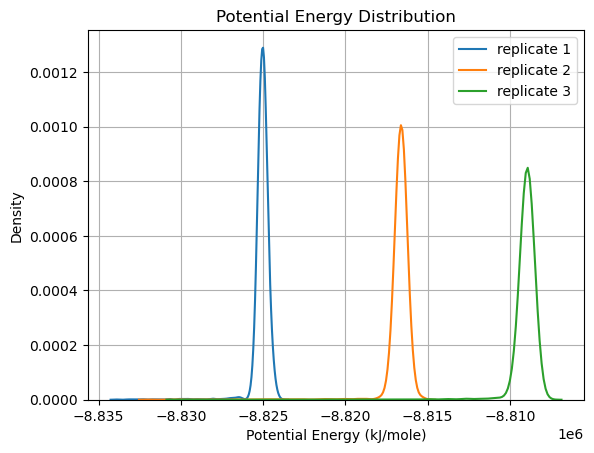

In [4]:
plot_potential_energy('openmm', ['classic/classic_ANI2x_longtime/data.csv',
                                 'classic/classic_ANI2x_longtime_400K/data.csv',
                                 'classic/classic_ANI2x_longtime_500K/data.csv'
                                 ], 'hist', 1)

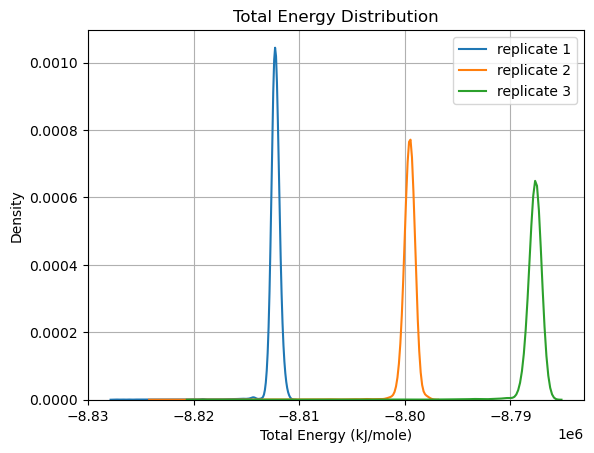

In [5]:
plot_total_energy('openmm', ['classic/classic_ANI2x_longtime/data.csv',
                                 'classic/classic_ANI2x_longtime_400K/data.csv',
                                 'classic/classic_ANI2x_longtime_500K/data.csv'
                                 ], 'hist', 1)

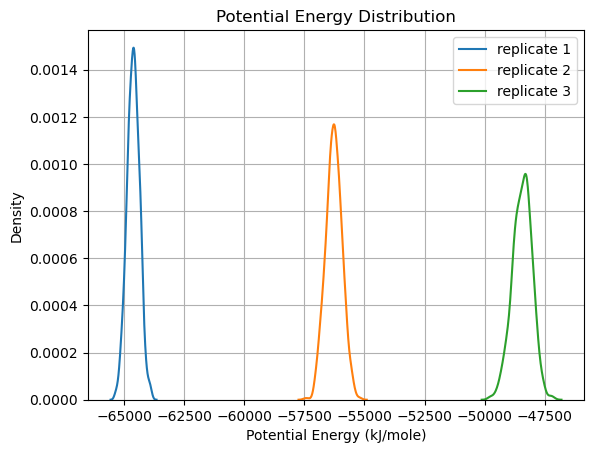

In [6]:
plot_potential_energy('openmm', ['classic/classic_sage/energy_data.csv',
                                 'classic/classic_sage_400K/energy_data.csv',
                                 'classic/classic_sage_500K/energy_data.csv'
                                 ], 'hist', 1)

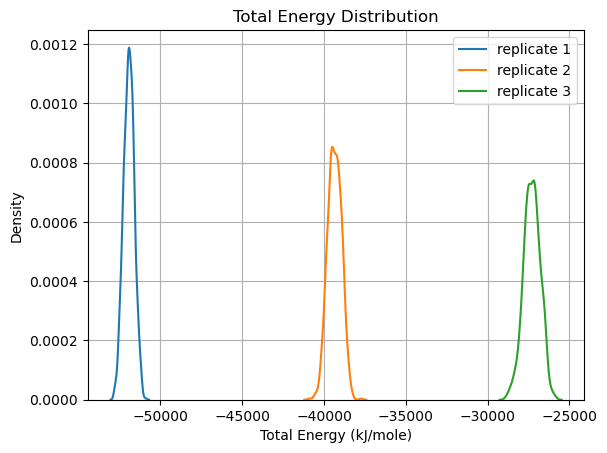

In [7]:
plot_total_energy('openmm', ['classic/classic_sage/energy_data.csv',
                                 'classic/classic_sage_400K/energy_data.csv',
                                 'classic/classic_sage_500K/energy_data.csv'
                                 ], 'hist', 1)

In [2]:
def plot_rmsd_fluctuations_multiple(traj_files, top_file, plot_type, window, saved_file_paths):
    rmsd_arrays = []
    labels = []
    for i, traj_file in enumerate(traj_files):
        traj = md.load(traj_file, top=top_file)
        try:
            traj.image_molecules(inplace=True)
        except:
            pass
        frames = np.arange(0, traj.n_frames)
        ligand_atoms = traj.topology.select('resname UNK')
        traj.superpose(traj, frame=0, atom_indices=ligand_atoms)
        traj.save(saved_file_paths[i])
        result = traj.xyz[:, ligand_atoms, :] - traj.xyz[0, ligand_atoms, :]
        ligand_rmsd = np.sqrt((result ** 2).sum(axis=-1).mean(axis=-1))
        n_windows = len(ligand_rmsd) // window
        avg_rmsd = np.array([ligand_rmsd[i*window:(i+1)*window].mean() for i in range(n_windows)])
        avg_frames = np.arange(n_windows) * window
        rmsd_arrays.append(avg_rmsd)
        labels.append(f'replicate {i+1}')
        if plot_type == 'line':
            plt.plot(avg_frames, avg_rmsd, label=labels[-1])
            plt.xlabel('Frames')
            plt.ylabel('RMSD (nm)')
            plt.title(f'Ligand RMSD under Protein Alignment')
        elif plot_type == 'hist':
            sns.kdeplot(avg_rmsd, label=labels[-1])
            plt.xlabel('RMSD (nm)')
            plt.title('Ligand RMSD Distribution under Protein Alignment')
    plt.grid(True)
    plt.legend()
    plt.show()
    plt.close()
    return traj

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


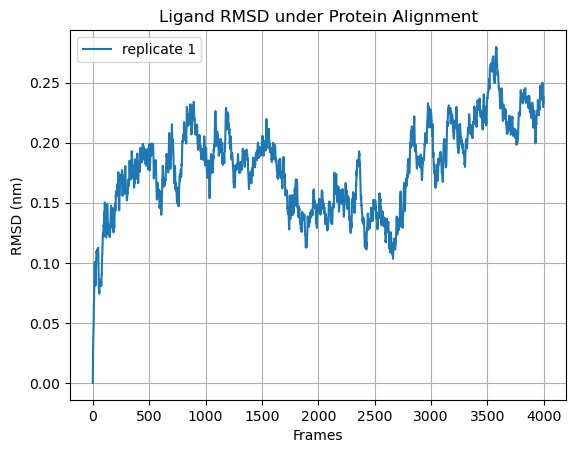

In [3]:
trj_ani_longtime  = plot_rmsd_fluctuations_multiple(['classic/classic_ANI2x_longtime/test_ani_mixed.dcd'], 'classic/classic_ANI2x_longtime/gaff_ligand_in_solvent.pdb', 'line', 1, ['classic/classic_ANI2x_longtime/processed.xtc'])

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


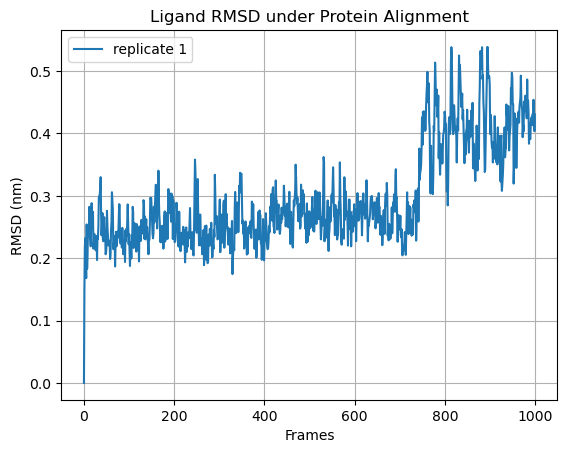

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


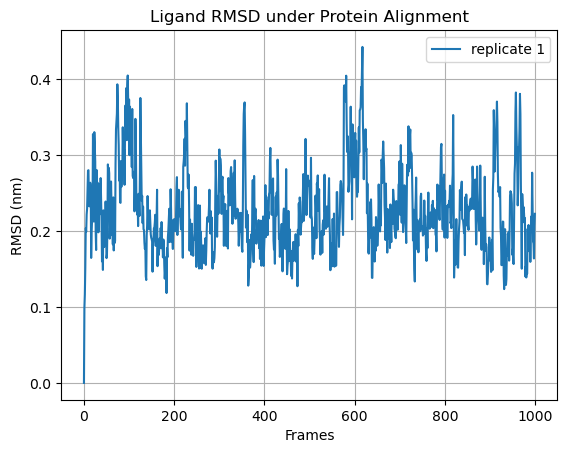

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


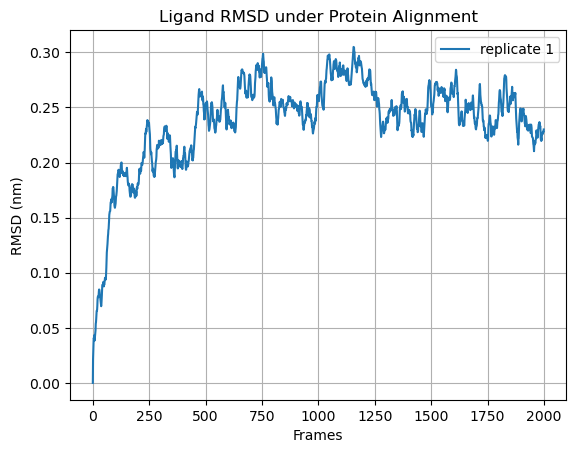

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


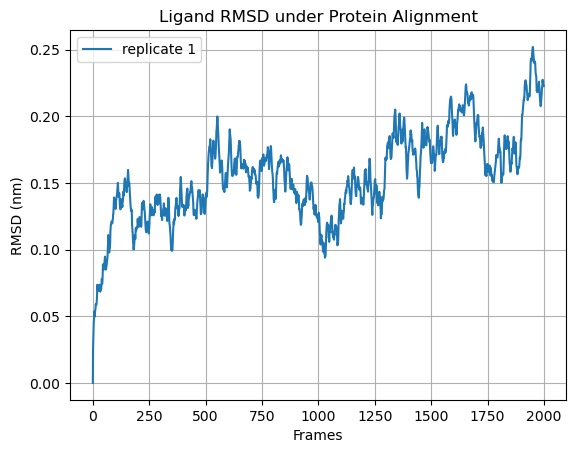

In [16]:
trj_gaff = plot_rmsd_fluctuations_multiple(['classic/classic_gaff/trajectory.dcd'], 'classic/classic_gaff/gaff_ligand_in_solvent.pdb', 'line', 1, ['classic/classic_gaff/processed.xtc'])
trj_sage = plot_rmsd_fluctuations_multiple(['classic/classic_sage/trajectory.dcd'], 'classic/classic_sage/ligand_in_solvent.pdb', 'line', 1, ['classic/classic_sage/processed.xtc'])
trj_ani  = plot_rmsd_fluctuations_multiple(['classic/classic_ANI2x/test_ani_mixed.dcd'], 'classic/classic_ANI2x/gaff_ligand_in_solvent.pdb', 'line', 1, ['classic/classic_ANI2x/processed.xtc'])
trj_mace = plot_rmsd_fluctuations_multiple(['classic/classic_MACEsmall/test_mace_mixed.dcd'], 'classic/classic_MACEsmall/gaff_ligand_in_solvent.pdb', 'line', 1, ['classic/classic_MACEsmall/processed.xtc'])

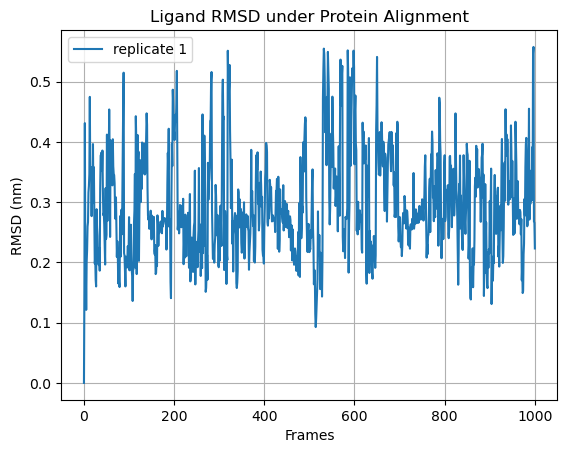

In [17]:
trj_sage_remd = plot_rmsd_fluctuations_multiple(['REMD/REMD_2/replicate_0/md_pbc_fit.xtc'], 'REMD/REMD_2/ligand_in_solvent.pdb', 'line', 1, ['REMD/REMD_2/0_processed.xtc'])

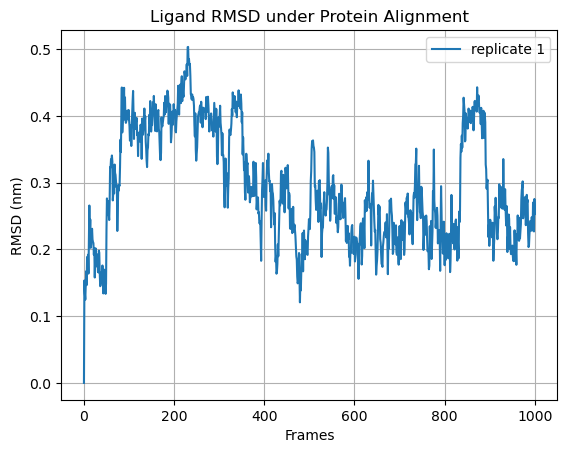

In [18]:
trj_sage_rest = plot_rmsd_fluctuations_multiple(['REST/REST_4/replica_0_ligand_samples.pdb'], 'REST/ligand.pdb', 'line', 1, ['REST/REST_4/0_processed.xtc'])

In [19]:
def plot_dihedral_angles(traj_cont, atom_indices):
    dihedral_angles = md.compute_dihedrals(traj_cont, [atom_indices])
    dihedral_angles_deg = np.degrees(dihedral_angles[:, 0])
    plt.figure(figsize=(8, 6))
    sns.kdeplot(dihedral_angles_deg)
    plt.xlabel('Dihedral Angle (degrees)')
    plt.ylabel('Density')
    plt.title('Dihedral Angle Distribution')
    plt.xlim(-180, 180)
    plt.grid(True)
    plt.show()
    plt.close()
    return np.mean(dihedral_angles_deg)

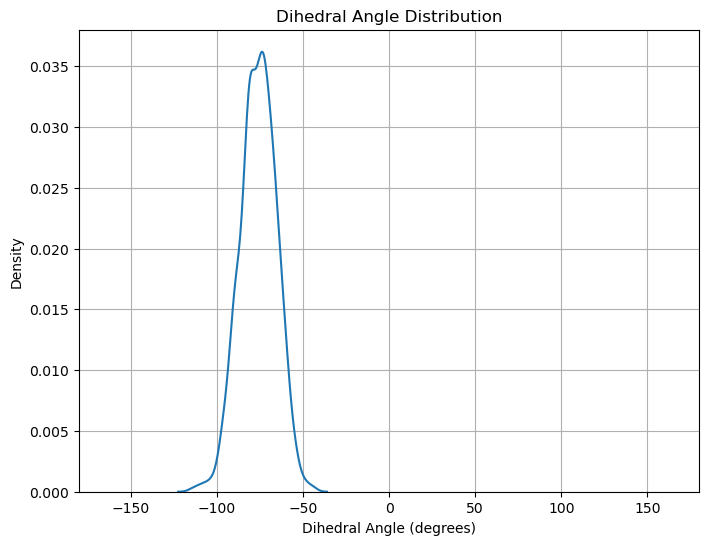

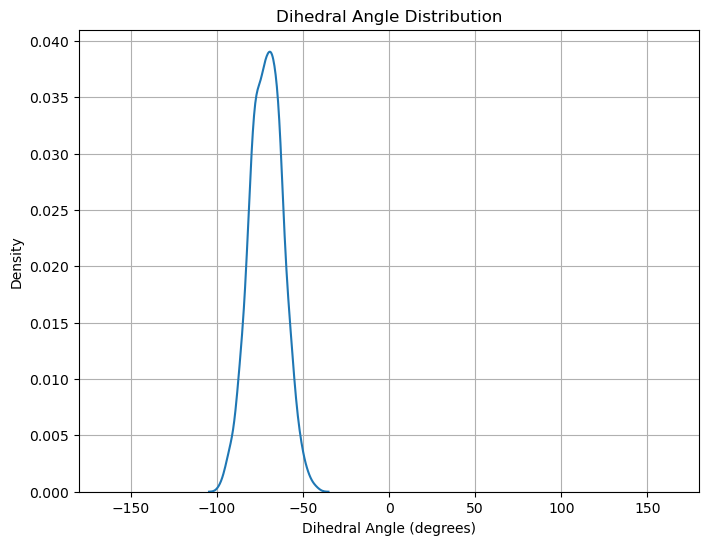

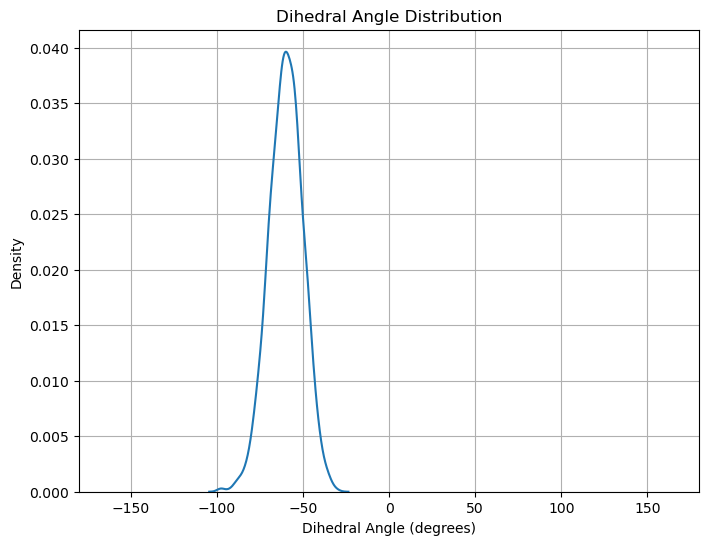

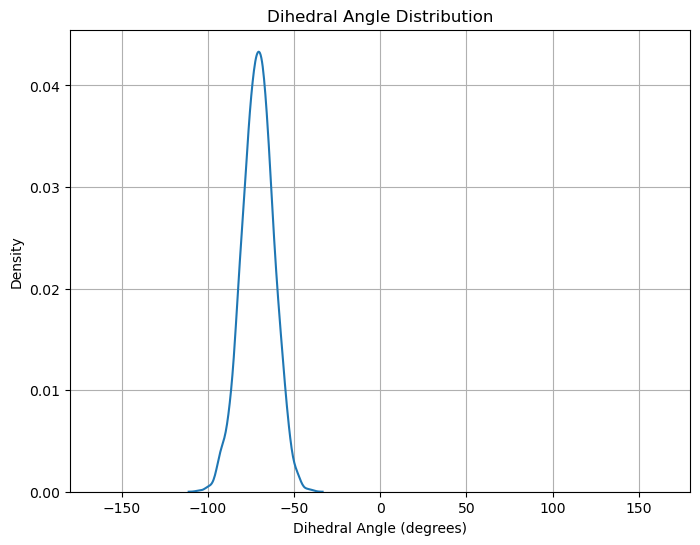

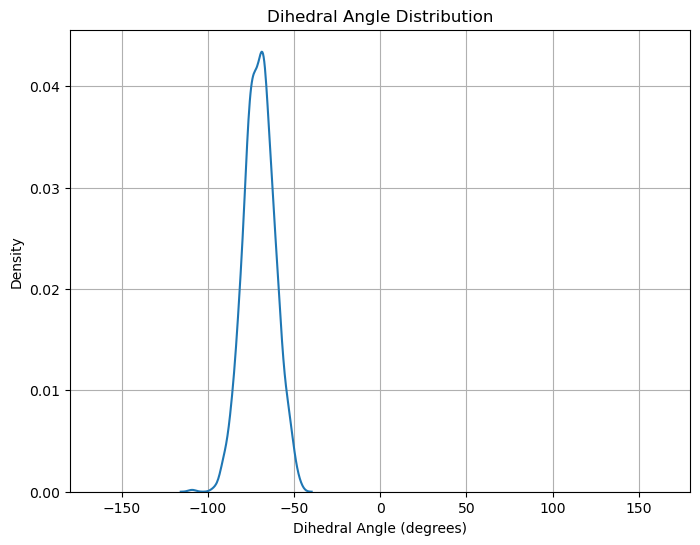

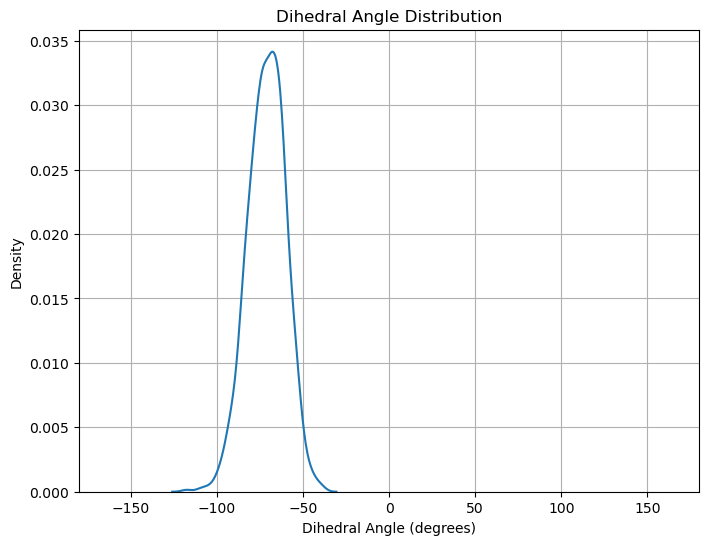

-71.1761

In [20]:
plot_dihedral_angles(trj_gaff, [11, 10, 9, 4])
plot_dihedral_angles(trj_sage, [11, 10, 9, 4])
plot_dihedral_angles(trj_ani, [11, 10, 9, 4])
plot_dihedral_angles(trj_mace, [11, 10, 9, 4])
plot_dihedral_angles(trj_sage_remd, [11, 10, 9, 4])
plot_dihedral_angles(trj_sage_rest, [11, 10, 9, 4])

In [21]:
def plot_distance(traj_cont, atom_indices):
    atom_pairs = np.array([atom_indices])
    distances = md.compute_distances(traj_cont, atom_pairs)
    distance = distances[:, 0]
    plt.figure(figsize=(8, 6))
    sns.kdeplot(distance)
    plt.xlabel('Distance (nm)')
    plt.ylabel('Density')
    plt.title('Distance Distribution')
    plt.xlim(0.3, 0.4)
    plt.grid(True)
    plt.show()
    plt.close()
    return np.mean(distance)

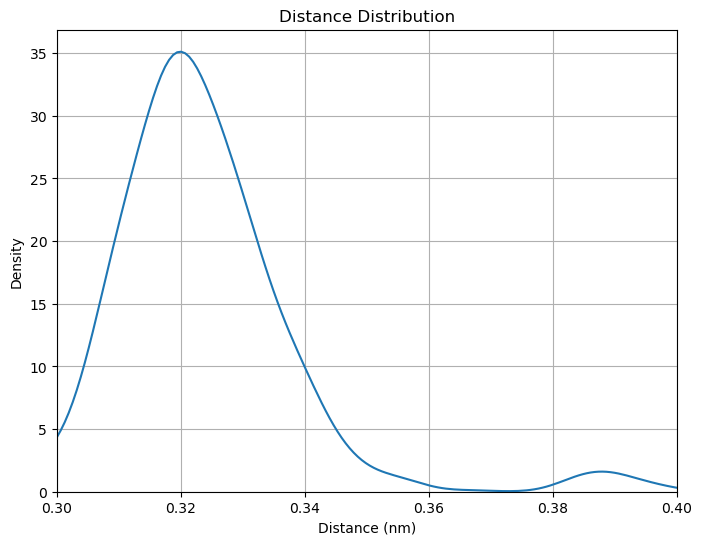

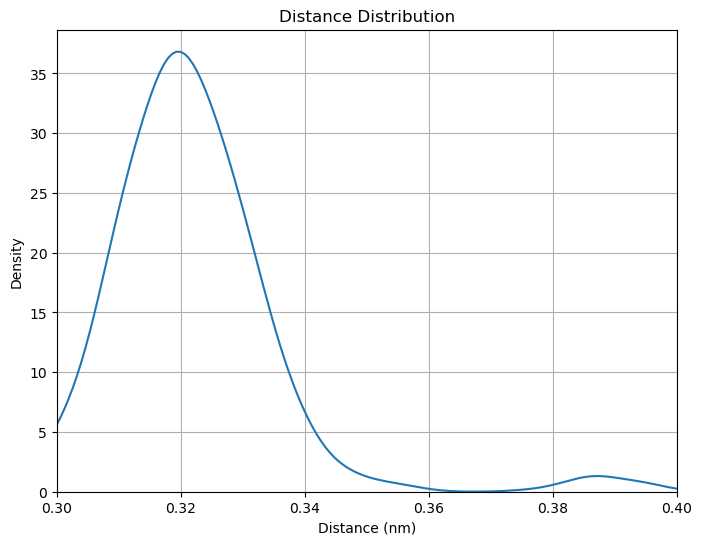

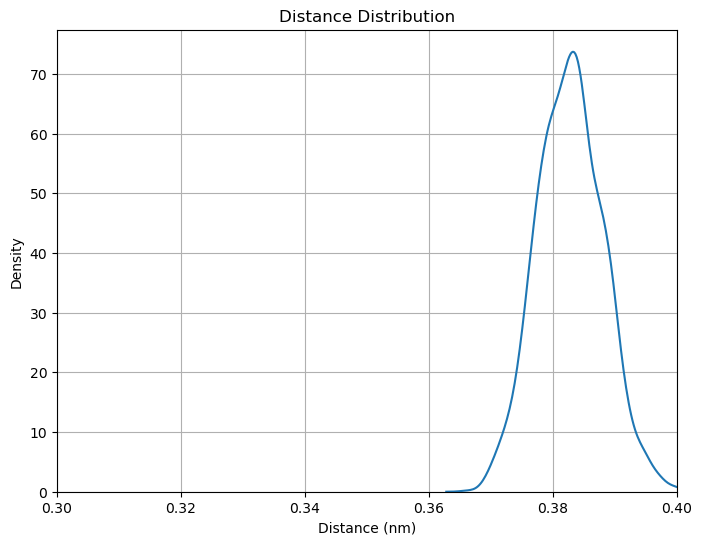

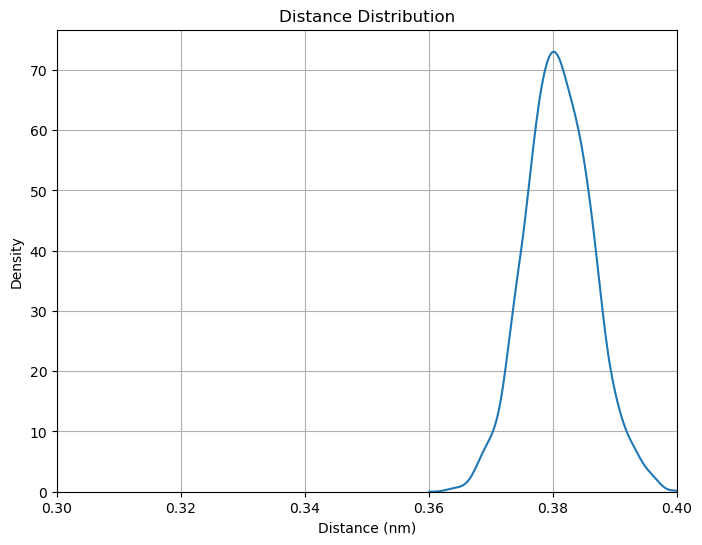

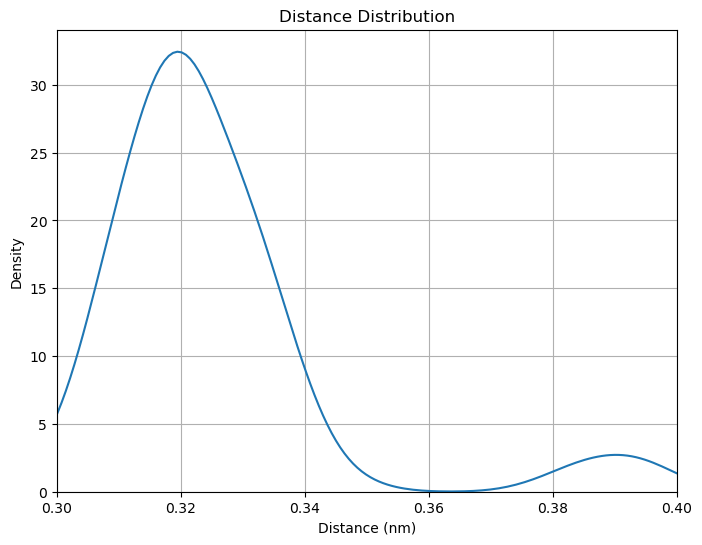

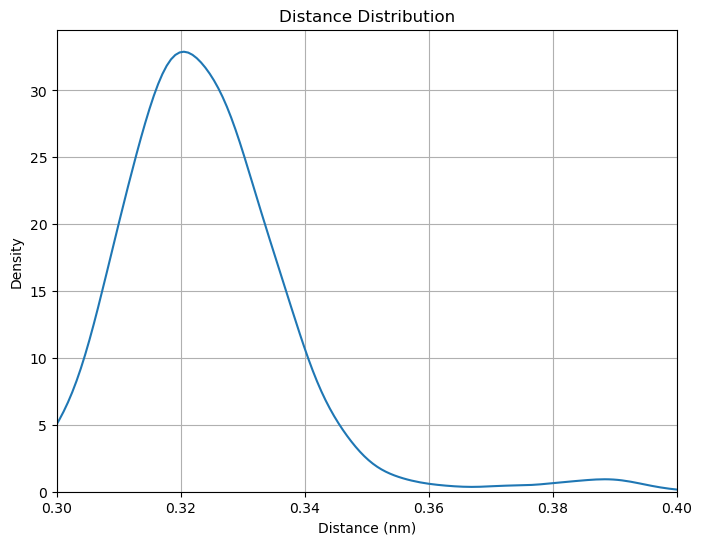

0.32365546

In [22]:
plot_distance(trj_gaff, [55, 58])
plot_distance(trj_sage, [55, 58])
plot_distance(trj_ani, [55, 58])
plot_distance(trj_mace, [55, 58])
plot_distance(trj_sage_remd, [55, 58])
plot_distance(trj_sage_rest, [55, 58])

In [24]:
def plot_ligand_pca(traj_files, top_file, slice_step=1):
        traj_cont = md.load(traj_files[0], top=top_file)[::slice_step]
        for i, traj_file in enumerate(traj_files[1:]):
                traj = md.load(traj_file, top=top_file)[::slice_step]
                traj_cont = md.join([traj_cont, traj])
        try:    
                traj_cont.image_molecules(inplace=True)
        except:
                pass
        ligand_atoms = traj_cont.topology.select('resname UNK')
        traj_cont.superpose(traj_cont, frame=0, atom_indices=ligand_atoms)
        ligand_xyz = traj_cont.xyz[:, ligand_atoms, :]
        ligand_xyz_flat = ligand_xyz.reshape(traj_cont.n_frames, len(ligand_atoms) * 3)
        pca1 = PCA(n_components=2)
        reduced_cartesian = pca1.fit_transform(ligand_xyz_flat)
        plt.figure(figsize=(8, 6))
        kde = sns.kdeplot(
                x=reduced_cartesian[:, 0],
                y=reduced_cartesian[:, 1],
                fill=True,
                cmap="viridis",
                thresh=0,
                levels=100
        )
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.title('KDE of Ligand PCA Coordinates')
        mappable = kde.collections[0]
        plt.colorbar(mappable, label='Density')
        plt.show()
        plt.close()
        return traj_cont

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


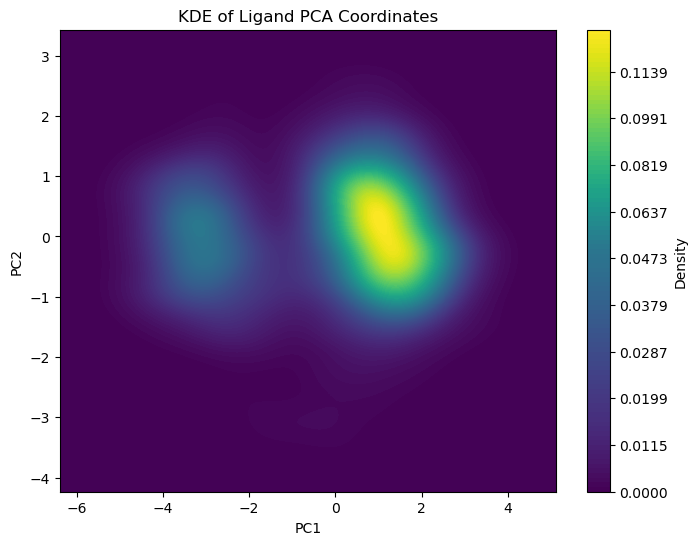

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


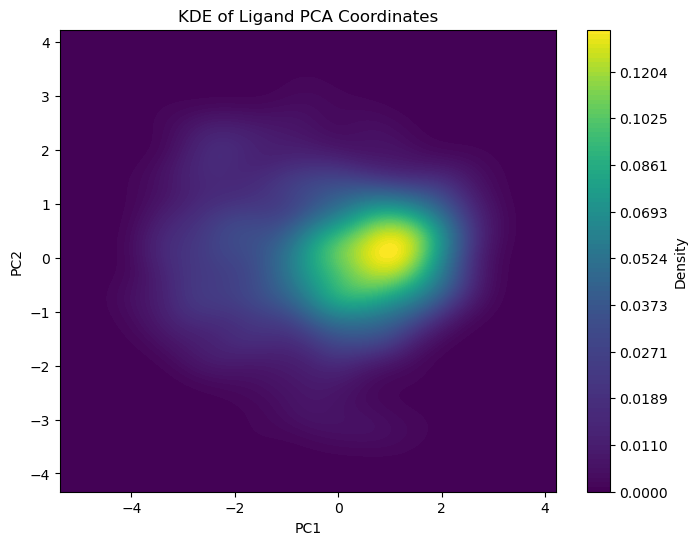

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


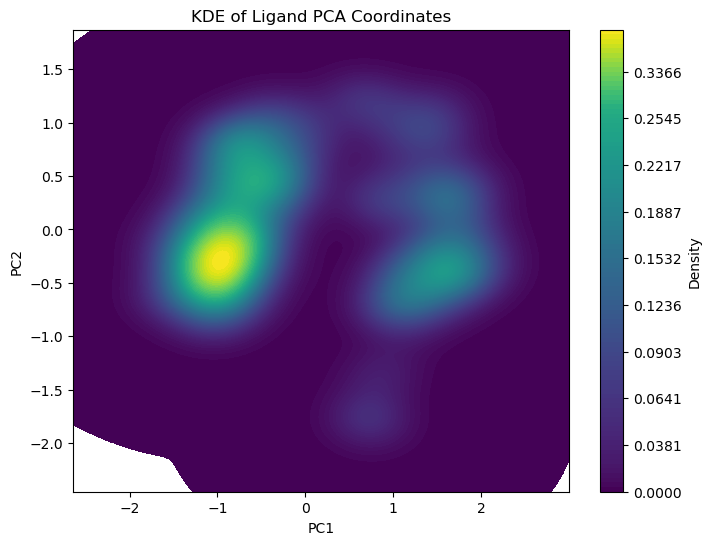

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


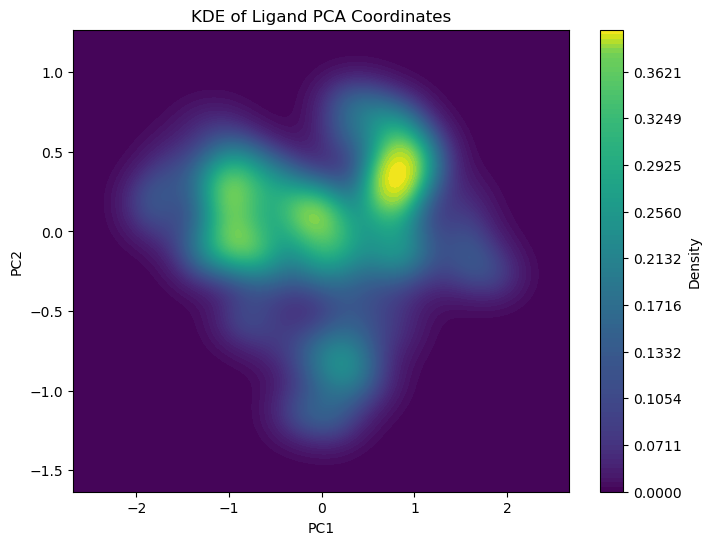

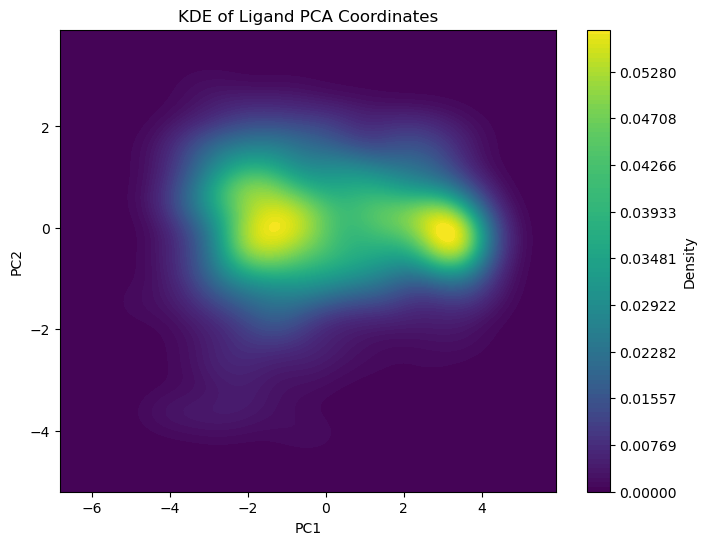

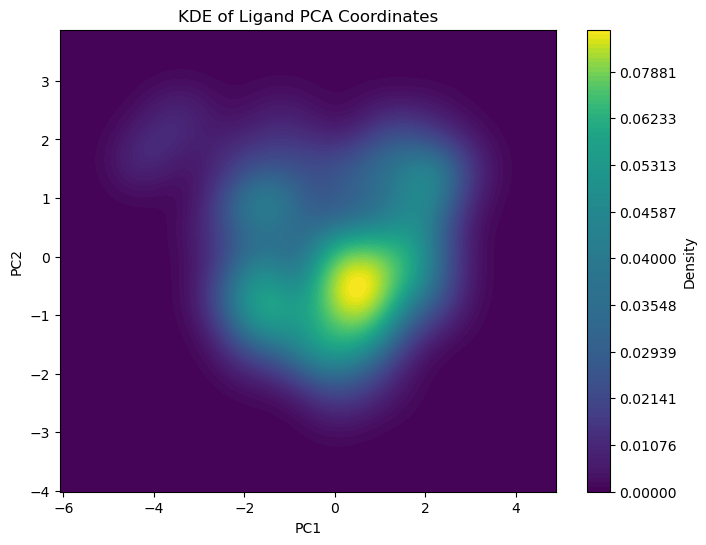

<mdtraj.Trajectory with 501 frames, 151 atoms, 1 residues, without unitcells at 0x7593afcf9950>

In [28]:
plot_ligand_pca(['classic/classic_gaff/trajectory.dcd'], 'classic/classic_gaff/gaff_ligand_in_solvent.pdb')
plot_ligand_pca(['classic/classic_sage/trajectory.dcd'], 'classic/classic_sage/ligand_in_solvent.pdb')
plot_ligand_pca(['classic/classic_ANI2x/test_ani_mixed.dcd'], 'classic/classic_ANI2x/gaff_ligand_in_solvent.pdb')
plot_ligand_pca(['classic/classic_MACEsmall/test_mace_mixed.dcd'], 'classic/classic_MACEsmall/gaff_ligand_in_solvent.pdb')
plot_ligand_pca(['REMD/REMD_2/0_sorted_md_pbc.xtc'], 'REMD/ligand_in_solvent.pdb')
plot_ligand_pca(['REST/REST_2/replica_0_ligand_samples.pdb'], 'REST/ligand.pdb')

In [12]:
import re
import os
import json
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
#
def extract_and_split_data(directory):
    all_data = []
    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as file:
                data = json.load(file)
                all_data.append({'filename': filename, 'energy': data["total energy"], 'HOMO_LUMO_gap': data["HOMO-LUMO gap / eV"]})
                df = pd.DataFrame(all_data)
    return df

df = extract_and_split_data('XTB_opt')
df
 

,filename,energy,HOMO_LUMO_gap
0,ANI2x_0001_opt.json,-221.318412,2.520763
1,ANI2x_0002_opt.json,-221.318331,2.539099
2,ANI2x_0003_opt.json,-221.319437,2.525212
3,ANI2x_0004_opt.json,-221.318942,2.535930
4,ANI2x_0005_opt.json,-221.319178,2.525628
...,...,...,...
15001,SAGE_0996_opt.json,-221.321926,2.631728
15002,SAGE_0997_opt.json,-221.325065,2.679623
15003,SAGE_0998_opt.json,-221.323575,2.700723
15004,SAGE_0999_opt.json,-221.323211,2.514509


In [13]:
df['method'] = df['filename'].apply(lambda x: x.split('_')[:-2])
df['method'] = df['method'].apply(lambda x: '_'.join(x))

In [ ]:
df_final = df[df['method'].isin(['GAFF', 'SAGE', 'ANI2x_L', 'MACEsmall', 'REMD', 'REST600d'])]
#
df_final['method'] = df_final['method'].apply(lambda x: 'GAFF 10 ns classic' if x == 'GAFF' else x)
df_final['method'] = df_final['method'].apply(lambda x: 'SAGE 10 ns classic' if x == 'SAGE' else x)
df_final['method'] = df_final['method'].apply(lambda x: 'SAGE 10 ns (16 REMD up to 475K)' if x == 'REMD' else x)
df_final['method'] = df_final['method'].apply(lambda x: 'SAGE 10 ns (16 REST up to 600K)' if x == 'REST600d' else x)
df_final['method'] = df_final['method'].apply(lambda x: 'ANI2x 0.2 ns (ML/MM)' if x == 'ANI2x_L' else x)
df_final['method'] = df_final['method'].apply(lambda x: 'MACEsmall 0.1 ns (ML/MM)' if x == 'MACEsmall' else x)

In [ ]:
df_final.rename(columns={'energy': 'XTB_opt_Energy (ALPB)', 'method': 'sampling method in explicit TIP3P'}, inplace=True)
df_final.sort_values(by='XTB_opt_Energy (ALPB)', inplace=True)
df_final.iloc[:100].to_csv('top_100_xtb_energies.csv', index=False)
top_10_per_group = df_final.groupby('sampling method in explicit TIP3P').head(10)
top_10_per_group.to_csv('top_10_xtb_energies_per_group.csv', index=False)

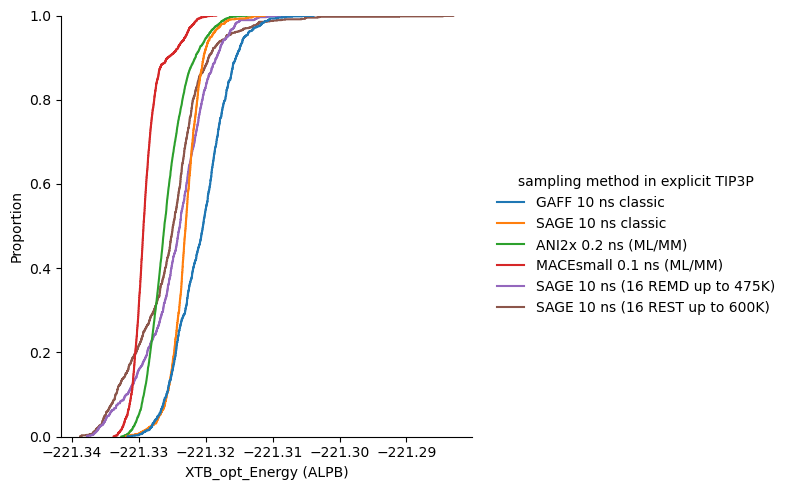

In [17]:
hue_order = ['GAFF 10 ns classic', 'SAGE 10 ns classic','ANI2x 0.2 ns (ML/MM)', 'MACEsmall 0.1 ns (ML/MM)', 'SAGE 10 ns (16 REMD up to 475K)', 'SAGE 10 ns (16 REST up to 600K)']
sns.displot(data=df_final, x='XTB_opt_Energy (ALPB)', kind='ecdf', hue='sampling method in explicit TIP3P', hue_order=hue_order)

In [18]:
for i in top_10_per_group['filename'].to_list():
    filename = i.split('.')[-2] + '.xyz'
    filepath = os.path.join('XTB_opt', filename)
    file_copy_path = os.path.join('dft_spe', filename)
    !cp {filepath} {file_copy_path}    

In [2]:
def prepare_orca_input(xyz_filepath):
    orca_header = [
        '! SP DFT wB97X-D3BJ def2-TZVP RIJCOSX LooseSCF',
        '! D3BJ',
        '! CPCM(water)',
        '%maxcore 4000',
        '%pal',
        '  NProcs 8',
        '  End',
        '* xyz 0 1'
    ]
    orca_trailer = ['*']
    base_name = os.path.splitext(xyz_filepath)[0]
    inp_filepath = base_name + '.inp'

    with open(xyz_filepath, 'r') as f:
        lines = f.readlines()
        
    coordinates = lines[2:]
    modified_content = (
        [line + '\n' for line in orca_header] + 
        coordinates + 
        [line + '\n' for line in orca_trailer]
    )
    
    with open(inp_filepath, 'w') as f:
        f.writelines(modified_content)

    return f"Successfully created ORCA input file: {inp_filepath}"

for filename in os.listdir('dft_spe'):
    if filename.endswith('.xyz'):
        filepath = os.path.join('dft_spe', filename)
        prepare_orca_input(filepath)

In [20]:
def extract_orca_final_energy(filepath):

    regex_pattern = r'&FinalEnergy\s+\[&Type "Double"\]\s*(-?\d+\.\d+(?:[Ee][+\-]?\d+)?)\s*"Final single point energy"'

    with open(filepath, 'r') as f:
        content = f.read()        
        match = re.search(regex_pattern, content)        
        if match:
            energy_str = match.group(1)
            energy = float(energy_str)
            print(f"Extracted Final Energy: {energy} Hartree (Eh)")
            return energy
        else:
            print("Final energy not found in the file.")
            return None

In [ ]:
def_energy_dict = {}
for filename in os.listdir('dft_spe'):
    if filename.endswith('.property.txt'):
        filepath = os.path.join('dft_spe', filename)
        basename = os.path.splitext(filename)[0].replace('.property', '.json')
        energy = extract_orca_final_energy(filepath)
        if energy is not None:
            def_energy_dict[basename] = energy

df_energy = pd.DataFrame.from_dict(def_energy_dict, orient='index', columns=['DFT_spe_Energy (CPCM)'])
df_energy.reset_index(inplace=True)
df_energy.rename(columns={'index': 'filename'}, inplace=True)

In [ ]:
df_energy_0 =pd.read_csv('top_10_xtb_energies_per_group.csv')
df_merged = pd.merge(df_energy_0, df_energy, on='filename', how='inner')
df_merged

<Axes: xlabel='XTB_opt_Energy (ALPB)', ylabel='DFT_spe_Energy (CPCM)'>

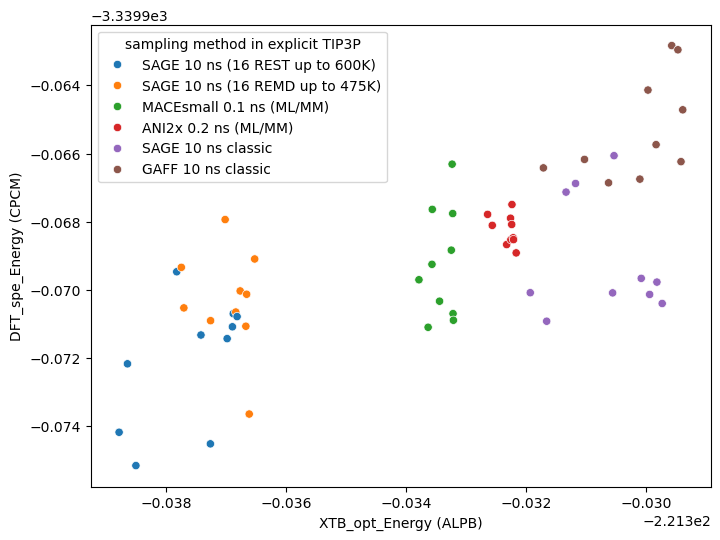

In [28]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 8, 6
sns.scatterplot(data=df_merged, x='XTB_opt_Energy (ALPB)', y='DFT_spe_Energy (CPCM)', hue='sampling method in explicit TIP3P')

In [29]:
df_merged.to_csv('xtb_dft_energy_comparison.csv', index=False)

In [8]:
df_merged = pd.read_csv('xtb_dft_energy_comparison.csv')

In [9]:
final_list = df_merged['filename'].apply(lambda x: x.split('.')[-2] + '.xyz').to_list()
!mkdir -p final_xyz
for i in final_list:
    filename = i
    filepath = os.path.join('XTB_opt', filename)
    file_copy_path = os.path.join('final_xyz', filename)
    !cp {filepath} {file_copy_path}

In [ ]:
for i in final_list:
    !python MMFF_models/eval_configs.py --configs final_xyz/{i} --model MMFF_models/MACE-OFF24_medium.model --output final_xyz/{i.split('.')[0]}_mace24medium.xyz --device cuda
    !python MMFF_models/eval_configs.py --configs final_xyz/{i} --model MMFF_models/MACE-OFF23_large.model --output final_xyz/{i.split('.')[0]}_mace23large.xyz --device cuda

In [10]:
#uma environment
from ase.io import read
from fairchem.core import FAIRChemCalculator
from fairchem.core.units.mlip_unit import load_predict_unit
#
esen_predictor = load_predict_unit(
    path="MMFF_models/esen_sm_conserving_all.pt",
    device="cuda",
)
esen_calculator = FAIRChemCalculator(esen_predictor)
#
omol25_energy_dict = {}
for i in final_list:
    atoms = read(f'final_xyz/{i}')
    atoms.info = {"charge": 0, "spin": 1}
    atoms.calc = esen_calculator
    energy_eV = atoms.get_potential_energy()
    omol25_energy_dict[i] = energy_eV

/home/haolan/anaconda3/envs/uma/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/haolan/anaconda3/envs/uma/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/haolan/anaconda3/envs/uma/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attr

In [11]:
import pickle
with open('omol25_energy_dict.pkl', 'wb') as f:
    pickle.dump(omol25_energy_dict, f)

In [15]:
with open('omol25_energy_dict.pkl', 'rb') as f:
    omol25_energy_dict = pickle.load(f)
omol25_energy_dict = dict(sorted(omol25_energy_dict.items(), key=lambda x: x[1]))
omol25_energy_dict

{'REST600d_0162_opt.xyz': -90810.96681472645,
 'REST600d_0167_opt.xyz': -90810.95283099994,
 'REST600d_0166_opt.xyz': -90810.94845077381,
 'REMD_0450_opt.xyz': -90810.91650173053,
 'REST600d_0157_opt.xyz': -90810.89895793781,
 'REST600d_0149_opt.xyz': -90810.86544582233,
 'REMD_0449_opt.xyz': -90810.86445781574,
 'REMD_0069_opt.xyz': -90810.86237880573,
 'REST600d_0179_opt.xyz': -90810.86036941395,
 'REMD_0063_opt.xyz': -90810.85176917896,
 'REMD_0279_opt.xyz': -90810.85096523151,
 'REMD_0062_opt.xyz': -90810.82923862324,
 'REST600d_0869_opt.xyz': -90810.82764407978,
 'REMD_0120_opt.xyz': -90810.82555553303,
 'REST600d_0860_opt.xyz': -90810.80794689045,
 'SAGE_0966_opt.xyz': -90810.80635616169,
 'REST600d_0844_opt.xyz': -90810.79997608051,
 'REMD_0960_opt.xyz': -90810.78907272205,
 'REST600d_0870_opt.xyz': -90810.77929851398,
 'REMD_0957_opt.xyz': -90810.77398750171,
 'SAGE_0968_opt.xyz': -90810.75111934528,
 'REMD_0943_opt.xyz': -90810.73437091694,
 'MACEsmall_1919_opt.xyz': -90810.71